In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 8.8 GB  | Proc size: 49.5 MB
GPU RAM Free: 2609MB | Used: 1487MB | Util  36% | Total 4096MB


In [1]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


In [2]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

In [22]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'\\*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs))
print(seqs)
print(len(seqs))
print(len(train_fnames))
print(len(split['test']))
print(len(seqs_train))
print(len(seqs_test))

['C:\\Users\\koral\\OneDrive - Imperial College London\\University\\Course\\4th Year\\Spring\\EE3-25 Deep Learning\\Coursework 2019\\keras_triplet_descriptor\\hpatches\\i_ajuntament', 'C:\\Users\\koral\\OneDrive - Imperial College London\\University\\Course\\4th Year\\Spring\\EE3-25 Deep Learning\\Coursework 2019\\keras_triplet_descriptor\\hpatches\\i_autannes', 'C:\\Users\\koral\\OneDrive - Imperial College London\\University\\Course\\4th Year\\Spring\\EE3-25 Deep Learning\\Coursework 2019\\keras_triplet_descriptor\\hpatches\\i_bologna', 'C:\\Users\\koral\\OneDrive - Imperial College London\\University\\Course\\4th Year\\Spring\\EE3-25 Deep Learning\\Coursework 2019\\keras_triplet_descriptor\\hpatches\\i_books', 'C:\\Users\\koral\\OneDrive - Imperial College London\\University\\Course\\4th Year\\Spring\\EE3-25 Deep Learning\\Coursework 2019\\keras_triplet_descriptor\\hpatches\\i_boutique', 'C:\\Users\\koral\\OneDrive - Imperial College London\\University\\Course\\4th Year\\Spring\\EE3


116
76
40
76
40


In [4]:
def get_denoise_model(shape):
    
  inputs = Input(shape)
  
  ## Encoder starts
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_net = Model(inputs = inputs, outputs = conv4)
  
  return shallow_net



def get_descriptor_model(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model
  
  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

In [28]:
shape = (32, 32, 1)
denoise_model = keras.models.load_model('./models/base/14epoch_denoise.h5')

In [29]:
sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
denoise_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


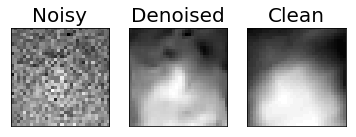

In [30]:
plot_denoise(denoise_model)

In [31]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [32]:
tmp_model = keras.models.load_model('./models/14epoch_descriptor.h5')
descriptor_model_trip.set_weights(tmp_model.get_weights())
descriptor_model_trip.optimizer = tmp_model.optimizer

In [33]:
print(len(seqs_test))

40


In [34]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model, use_clean=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [06:09<00:00,  8.13s/it]


In [35]:
#!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=.\out\ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

Verification task results:
Mean Average Precision is 0.813688


In [36]:
#!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=.\out\ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

Matching task results:
Mean Average Precision is 0.213871




In [37]:
#!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=.\out\ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

Retrieval task results:
Mean Average Precision is 0.511539


In [16]:
#!zip -rq descriptors.zip ./out/custom

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(denoise_model, to_file='denoise_model_plot.png', show_shapes=True, show_layer_names=True)
plot_model(descriptor_model, to_file='descriptor_model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
denoise_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 32)   4640        max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
up_samplin

In [21]:
descriptor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
__________